In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine, text
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn
import psycopg2
import os
from dotenv import load_dotenv

In [2]:
# Load .env file that contains the database URL as an environment variable
load_dotenv("dburl.env")

# os.environ is a dictionary that contains all the environment variables, so we can access the database URL using its key
DB_connection_URL = os.environ["database_url"]

# Create a SQLAlchemy engine using the connection string to connect to project database at NeonDB
engine = create_engine(DB_connection_URL)

# Define SQL query to extract raw data from NeonDB
rawdata_query = text("SELECT * FROM loan_data;")

with engine.connect() as connection:
    rawdata_df = pd.read_sql(rawdata_query, connection)

display(rawdata_df.head())
display(rawdata_df.info())
display(rawdata_df.columns.tolist())

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyIncome,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,3329.000000,0.724972,11,126928,0.199652,0.227590,419.805992,0.181077,0,49.0
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,3309.083333,0.935132,3,43609,0.207045,0.201077,794.054238,0.389852,0,52.0
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,3393.666667,0.872241,6,5205,0.217627,0.212548,666.406688,0.462157,0,52.0
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,5757.000000,0.896155,5,99452,0.300398,0.300911,1047.506980,0.313098,0,54.0
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,8605.333333,0.941369,5,227019,0.197184,0.175990,330.179140,0.070210,1,36.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             20000 non-null  object 
 1   Age                         20000 non-null  int64  
 2   AnnualIncome                20000 non-null  int64  
 3   CreditScore                 20000 non-null  int64  
 4   EmploymentStatus            20000 non-null  object 
 5   EducationLevel              20000 non-null  object 
 6   Experience                  20000 non-null  int64  
 7   LoanAmount                  20000 non-null  int64  
 8   LoanDuration                20000 non-null  int64  
 9   MaritalStatus               20000 non-null  object 
 10  NumberOfDependents          20000 non-null  int64  
 11  HomeOwnershipStatus         20000 non-null  object 
 12  MonthlyDebtPayments         20000 non-null  int64  
 13  CreditCardUtilizationRate   200

None

['ApplicationDate',
 'Age',
 'AnnualIncome',
 'CreditScore',
 'EmploymentStatus',
 'EducationLevel',
 'Experience',
 'LoanAmount',
 'LoanDuration',
 'MaritalStatus',
 'NumberOfDependents',
 'HomeOwnershipStatus',
 'MonthlyDebtPayments',
 'CreditCardUtilizationRate',
 'NumberOfOpenCreditLines',
 'NumberOfCreditInquiries',
 'DebtToIncomeRatio',
 'BankruptcyHistory',
 'LoanPurpose',
 'PreviousLoanDefaults',
 'PaymentHistory',
 'LengthOfCreditHistory',
 'SavingsAccountBalance',
 'CheckingAccountBalance',
 'TotalAssets',
 'TotalLiabilities',
 'MonthlyIncome',
 'UtilityBillsPaymentHistory',
 'JobTenure',
 'NetWorth',
 'BaseInterestRate',
 'InterestRate',
 'MonthlyLoanPayment',
 'TotalDebtToIncomeRatio',
 'LoanApproved',
 'RiskScore']

In [3]:
# Define SQL query to extract feature engineered data from NeonDB
featuredata_query = text("""
SELECT
    CASE
        WHEN "Age" < 25 THEN '18-24'
        WHEN "Age" < 35 THEN '25-34'
        WHEN "Age" < 45 THEN '35-44'
        WHEN "Age" < 60 THEN '45-59'
        ELSE '60+'
    END AS age_band,
    CASE
        WHEN "AnnualIncome" < 30000 THEN '<30k'
        WHEN "AnnualIncome" < 60000 THEN '30k-60k'
        WHEN "AnnualIncome" < 100000 THEN '60k-100k'
        ELSE '100k+'
    END AS income_band,
    CASE
        WHEN "LoanAmount" < 5000 THEN '<5k'
        WHEN "LoanAmount" < 20000 THEN '5k-20k'
        WHEN "LoanAmount" < 50000 THEN '20k-50k'
        ELSE '50k+'
    END AS loan_amount_band,
    CASE
        WHEN "LoanDuration" <= 12 THEN '<=12m'
        WHEN "LoanDuration" <= 36 THEN '13-36m'
        WHEN "LoanDuration" <= 60 THEN '37-60m'
        ELSE '60m+'
    END AS loan_duration_band,
    CASE
        WHEN "RiskScore" < 40 THEN 'Low'
        WHEN "RiskScore" < 70 THEN 'Medium'
        ELSE 'High'
    END AS risk_band,
    CASE
        WHEN "MonthlyIncome" > 0 THEN "MonthlyLoanPayment"::numeric / "MonthlyIncome"
        ELSE NULL
    END AS payment_to_income_ratio
FROM loan_data;
""")

with engine.connect() as connection:
    featuredata_df = pd.read_sql(featuredata_query, connection)

display(featuredata_df.head())

,age_band,income_band,loan_amount_band,loan_duration_band,risk_band,payment_to_income_ratio
0,45-59,30k-60k,5k-20k,37-60m,Medium,0.126106
1,35-44,30k-60k,20k-50k,37-60m,Medium,0.239962
2,45-59,30k-60k,5k-20k,13-36m,Medium,0.196368
3,45-59,60k-100k,20k-50k,60m+,Medium,0.181954
4,35-44,100k+,5k-20k,13-36m,Low,0.038369


In [4]:
display(featuredata_df.info())
display(featuredata_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_band                 20000 non-null  object 
 1   income_band              20000 non-null  object 
 2   loan_amount_band         20000 non-null  object 
 3   loan_duration_band       20000 non-null  object 
 4   risk_band                20000 non-null  object 
 5   payment_to_income_ratio  20000 non-null  float64
dtypes: float64(1), object(5)
memory usage: 937.6+ KB


None

age_band                   0
income_band                0
loan_amount_band           0
loan_duration_band         0
risk_band                  0
payment_to_income_ratio    0
dtype: int64

In [5]:
# start from raw
model_df = rawdata_df.copy()

# add engineered cols
for col in featuredata_df.columns:
    model_df[col] = featuredata_df[col]

display(model_df.head())
model_df.info()
display(model_df.describe())

,ApplicationDate,Age,AnnualIncome,CreditScore,EmploymentStatus,EducationLevel,Experience,LoanAmount,LoanDuration,MaritalStatus,...,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore,age_band,income_band,loan_amount_band,loan_duration_band,risk_band,payment_to_income_ratio
0,2018-01-01,45,39948,617,Employed,Master,22,13152,48,Married,...,419.805992,0.181077,0,49.0,45-59,30k-60k,5k-20k,37-60m,Medium,0.126106
1,2018-01-02,38,39709,628,Employed,Associate,15,26045,48,Single,...,794.054238,0.389852,0,52.0,35-44,30k-60k,20k-50k,37-60m,Medium,0.239962
2,2018-01-03,47,40724,570,Employed,Bachelor,26,17627,36,Married,...,666.406688,0.462157,0,52.0,45-59,30k-60k,5k-20k,13-36m,Medium,0.196368
3,2018-01-04,58,69084,545,Employed,High School,34,37898,96,Single,...,1047.506980,0.313098,0,54.0,45-59,60k-100k,20k-50k,60m+,Medium,0.181954
4,2018-01-05,37,103264,594,Employed,Associate,17,9184,36,Married,...,330.179140,0.070210,1,36.0,35-44,100k+,5k-20k,13-36m,Low,0.038369


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ApplicationDate             20000 non-null  object 
 1   Age                         20000 non-null  int64  
 2   AnnualIncome                20000 non-null  int64  
 3   CreditScore                 20000 non-null  int64  
 4   EmploymentStatus            20000 non-null  object 
 5   EducationLevel              20000 non-null  object 
 6   Experience                  20000 non-null  int64  
 7   LoanAmount                  20000 non-null  int64  
 8   LoanDuration                20000 non-null  int64  
 9   MaritalStatus               20000 non-null  object 
 10  NumberOfDependents          20000 non-null  int64  
 11  HomeOwnershipStatus         20000 non-null  object 
 12  MonthlyDebtPayments         20000 non-null  int64  
 13  CreditCardUtilizationRate   200

,Age,AnnualIncome,CreditScore,Experience,LoanAmount,LoanDuration,NumberOfDependents,MonthlyDebtPayments,CreditCardUtilizationRate,NumberOfOpenCreditLines,...,UtilityBillsPaymentHistory,JobTenure,NetWorth,BaseInterestRate,InterestRate,MonthlyLoanPayment,TotalDebtToIncomeRatio,LoanApproved,RiskScore,payment_to_income_ratio
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,39.752600,59161.473550,571.612400,17.522750,24882.867800,54.057000,1.517300,454.292700,0.286381,3.023350,...,0.799918,5.002650,7.229432e+04,0.239124,0.239110,911.607052,0.402182,0.239000,50.766780,0.268457
std,11.622713,40350.845168,50.997358,11.316836,13427.421217,24.664857,1.386325,240.507609,0.159793,1.736161,...,0.120665,2.236804,1.179200e+05,0.035509,0.042205,674.583473,0.338924,0.426483,7.778262,0.273757
min,18.000000,15000.000000,343.000000,0.000000,3674.000000,12.000000,0.000000,50.000000,0.000974,0.000000,...,0.259203,0.000000,1.000000e+03,0.130101,0.113310,97.030193,0.016043,0.000000,28.800000,0.008544
25%,32.000000,31679.000000,540.000000,9.000000,15575.000000,36.000000,0.000000,286.000000,0.160794,2.000000,...,0.727379,3.000000,8.734750e+03,0.213889,0.209142,493.763700,0.179693,0.000000,46.000000,0.100752
50%,40.000000,48566.000000,578.000000,17.000000,21914.500000,48.000000,1.000000,402.000000,0.266673,3.000000,...,0.820962,5.000000,3.285550e+04,0.236157,0.235390,728.511452,0.302711,0.000000,52.000000,0.183596
75%,48.000000,74391.000000,609.000000,25.000000,30835.000000,72.000000,2.000000,564.000000,0.390634,4.000000,...,0.892333,6.000000,8.882550e+04,0.261533,0.265532,1112.770759,0.509214,0.000000,56.000000,0.334639
max,80.000000,485341.000000,712.000000,61.000000,184732.000000,120.000000,5.000000,2919.000000,0.917380,13.000000,...,0.999433,16.000000,2.603208e+06,0.405029,0.446787,10892.629520,4.647657,1.000000,84.000000,4.190057


In [6]:
display(
    # Shows percentages of approved vs not approved loans in the dataset.
    model_df["LoanApproved"].value_counts()/len(model_df)*100,
    # Shows counts of each risk band in the dataset. How many low, medium, high risk borrowers are there?
    model_df["risk_band"].value_counts(), 
    # Shows approval rates across different risk bands (mean is same as approval rate since LoanApproved is binary, 0, 1)
    model_df.groupby("risk_band")["LoanApproved"].mean(),
    # Shows approval rates across different income bands within each risk band. How many loans are approved for low, medium, high risk borrowers at different income levels?
    model_df.groupby(["risk_band", "income_band"])["LoanApproved"].mean().unstack(),
    # Shows approval rates across different loan amount bands within each risk band. How many loans are approved for low, medium, high risk borrowers at different loan amounts?
    model_df.groupby(["risk_band", "loan_amount_band"])["LoanApproved"].mean().unstack()
)

#Overall this code will help in understand the distribution and approval rates of loans based on risk scores, income levels, and loan amounts.

LoanApproved
0    76.1
1    23.9
Name: count, dtype: float64

risk_band
Medium    17619
Low        2221
High        160
Name: count, dtype: int64

risk_band
High      0.000000
Low       0.998649
Medium    0.145411
Name: LoanApproved, dtype: float64

income_band,100k+,30k-60k,60k-100k,<30k
risk_band,,,,
High,0.000000,0.000000,0.000000,0.000000
Low,1.000000,0.994975,0.998822,1.000000
Medium,0.682642,0.053631,0.271896,0.005002


loan_amount_band,20k-50k,50k+,5k-20k,<5k
risk_band,,,,
High,0.000000,0.000000,0.000000,0.000000
Low,0.997893,0.952381,1.000000,1.000000
Medium,0.089077,0.013861,0.235181,0.423077


The above analysis shows... 

In [7]:
display(
    # Shows how much of the borrower's income is being used to pay the loan across different risk bands.
    model_df.groupby("risk_band")["payment_to_income_ratio"].median(),
    # Shows overall statistics of payment to income ratio. Basically 
    model_df["payment_to_income_ratio"].describe(),
    # Shows payment to income ratio for approved loans across different risk bands.It differs from above as it shows borrowers who were approved, because other borrower may be paying for other loans but were not approved for this one.
    model_df[model_df["LoanApproved"] == 1].groupby("risk_band")["payment_to_income_ratio"].median(),
)



risk_band
High      0.240386
Low       0.081882
Medium    0.203903
Name: payment_to_income_ratio, dtype: float64

count    20000.000000
mean         0.268457
std          0.273757
min          0.008544
25%          0.100752
50%          0.183596
75%          0.334639
max          4.190057
Name: payment_to_income_ratio, dtype: float64

risk_band
Low       0.081802
Medium    0.075864
Name: payment_to_income_ratio, dtype: float64

In [8]:
# Focus only on medium risk borrowers
medium_df = model_df[model_df["risk_band"] == "Medium"].copy()

display(
# Shows approval rates for medium risk borrowers.
medium_df["LoanApproved"].value_counts()/len(medium_df)*100,
# Shows median payment to income ratio for approved vs not approved loans among medium risk borrowers. Why median? Because payment to income ratio can be skewed by outliers.
medium_df.groupby("LoanApproved")["payment_to_income_ratio"].median(),
# Shows approval rates across different income bands among medium risk borrowers. Similar to previous but only for medium risk borrowers. 
medium_df.groupby("income_band")["LoanApproved"].mean().sort_values()
)

LoanApproved
0    85.45888
1    14.54112
Name: count, dtype: float64

LoanApproved
0    0.235986
1    0.075864
Name: payment_to_income_ratio, dtype: float64

income_band
<30k        0.005002
30k-60k     0.053631
60k-100k    0.271896
100k+       0.682642
Name: LoanApproved, dtype: float64

In [9]:
ml_cols = [
    # risk & affordability
    "RiskScore",
    "CreditScore",
    "DebtToIncomeRatio",
    "TotalDebtToIncomeRatio",
    "payment_to_income_ratio",

    # income / size / tenor
    "AnnualIncome",
    "LoanAmount",
    "LoanDuration",

    # historical behavior
    "PreviousLoanDefaults",
    "BankruptcyHistory",

    # binned categorical views (easier to explain)
    "risk_band",
    "income_band",
    "loan_amount_band",
    "loan_duration_band",
]

# Build ML dataset = selected features + target
ml_df = model_df[ml_cols + ["LoanApproved"]].copy()

display(ml_df.head())
ml_df.info()

,RiskScore,CreditScore,DebtToIncomeRatio,TotalDebtToIncomeRatio,payment_to_income_ratio,AnnualIncome,LoanAmount,LoanDuration,PreviousLoanDefaults,BankruptcyHistory,risk_band,income_band,loan_amount_band,loan_duration_band,LoanApproved
0,49.0,617,0.358336,0.181077,0.126106,39948,13152,48,0,0,Medium,30k-60k,5k-20k,37-60m,0
1,52.0,628,0.330274,0.389852,0.239962,39709,26045,48,0,0,Medium,30k-60k,20k-50k,37-60m,0
2,52.0,570,0.244729,0.462157,0.196368,40724,17627,36,0,0,Medium,30k-60k,5k-20k,13-36m,0
3,54.0,545,0.436244,0.313098,0.181954,69084,37898,96,0,0,Medium,60k-100k,20k-50k,60m+,0
4,36.0,594,0.078884,0.070210,0.038369,103264,9184,36,0,0,Low,100k+,5k-20k,13-36m,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   RiskScore                20000 non-null  float64
 1   CreditScore              20000 non-null  int64  
 2   DebtToIncomeRatio        20000 non-null  float64
 3   TotalDebtToIncomeRatio   20000 non-null  float64
 4   payment_to_income_ratio  20000 non-null  float64
 5   AnnualIncome             20000 non-null  int64  
 6   LoanAmount               20000 non-null  int64  
 7   LoanDuration             20000 non-null  int64  
 8   PreviousLoanDefaults     20000 non-null  int64  
 9   BankruptcyHistory        20000 non-null  int64  
 10  risk_band                20000 non-null  object 
 11  income_band              20000 non-null  object 
 12  loan_amount_band         20000 non-null  object 
 13  loan_duration_band       20000 non-null  object 
 14  LoanApproved          

In [10]:
# Numeric columns: continuous / count fields
numeric_features = [
    "RiskScore",
    "CreditScore",
    "DebtToIncomeRatio",
    "TotalDebtToIncomeRatio",
    "payment_to_income_ratio",
    "AnnualIncome",
    "LoanAmount",
    "LoanDuration",
    "PreviousLoanDefaults",
    "BankruptcyHistory",
]

# Categorical columns: bands fron engineered features
categorical_features = [
    "risk_band",
    "income_band",
    "loan_amount_band",
    "loan_duration_band",
]

X = ml_df[numeric_features + categorical_features]
y = ml_df["LoanApproved"]


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 1) Train / test split
#    - test_size=0.2 -> 20% test set
#    - stratify=y -> keep same approval rate proportion in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2) Preprocessing:
#    - numeric: StandardScaler (mean 0, std 1)
#    - categorical: OneHotEncoder -> turns bands into 0/1 columns
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# 3) Model:
#    LogisticRegression is simple + interpretable.
#    max_iter=1000: just to make sure it converges.
log_reg = LogisticRegression(max_iter=1000)

# 4) Full pipeline: preprocessing + model in one object
clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", log_reg),
    ]
)

# 5) Fit model to training data
clf.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers co

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on test set
y_pred = clf.predict(X_test)

# Accuracy: how often we match the bank's decision
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {acc:.3f}")

# Confusion matrix: how often we miss approvals vs rejections
print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred))

# More detailed metrics (precision/recall/F1) per class
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))

from sklearn.metrics import roc_auc_score

y_test_probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_test_probs)
print(f"Test ROC-AUC: {auc:.3f}")


Test accuracy: 0.997
Confusion matrix (rows=true, cols=pred):
[[3037    7]
 [   7  949]]

Classification report:
              precision    recall  f1-score   support

           0      0.998     0.998     0.998      3044
           1      0.993     0.993     0.993       956

    accuracy                          0.997      4000
   macro avg      0.995     0.995     0.995      4000
weighted avg      0.997     0.997     0.997      4000

Test ROC-AUC: 1.000


In [13]:
# Get the fitted logistic regression from the pipeline
log_reg_fitted = clf.named_steps["model"]
preprocessor_fitted = clf.named_steps["preprocessor"]

# 1) Get feature names after preprocessing
#    - For numeric: same names
#    - For categorical: OneHotEncoder creates new columns
num_feature_names = numeric_features

cat_encoder = preprocessor_fitted.named_transformers_["cat"]
cat_feature_names = cat_encoder.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([num_feature_names, cat_feature_names])

# 2) Get coefficients from logistic regression
#    coef_ is shape (1, n_features) for binary classification
coefs = log_reg_fitted.coef_[0]

feature_importance_df = (
    pd.DataFrame({
        "feature": all_feature_names,
        "coefficient": coefs
    })
    .sort_values(by="coefficient", ascending=False)
)

# Positive coefficient -> pushes towards APPROVAL (1)
# Negative coefficient -> pushes towards REJECTION (0)


In [14]:
# Show top 10 features pushing for approval 
# and top 10 pushing for rejection
display(
    feature_importance_df.head(10),
    feature_importance_df.tail(10)
)

,feature,coefficient
2,DebtToIncomeRatio,2.819857
9,BankruptcyHistory,2.177521
8,PreviousLoanDefaults,1.298233
5,AnnualIncome,0.841090
10,risk_band_High,-0.006753
24,loan_duration_band_<=12m,-0.066763
20,loan_amount_band_<5k,-0.073818
18,loan_amount_band_50k+,-0.313695
13,income_band_100k+,-0.336184
16,income_band_<30k,-0.345839


,feature,coefficient
14,income_band_30k-60k,-0.739572
22,loan_duration_band_37-60m,-0.845406
17,loan_amount_band_20k-50k,-0.909941
7,LoanDuration,-0.968052
1,CreditScore,-0.987612
6,LoanAmount,-1.258579
12,risk_band_Medium,-1.369320
4,payment_to_income_ratio,-1.617036
3,TotalDebtToIncomeRatio,-2.571656
0,RiskScore,-9.263740


In [15]:
# Predicted approval probabilities for all borrowers
pred_probs = clf.predict_proba(X)[:, 1]
# Make a copy of ml_df and add the predicted probability column
policy_df = ml_df.copy()
policy_df["pred_approval_prob"] = pred_probs

policy_df.head()

,RiskScore,CreditScore,DebtToIncomeRatio,TotalDebtToIncomeRatio,payment_to_income_ratio,AnnualIncome,LoanAmount,LoanDuration,PreviousLoanDefaults,BankruptcyHistory,risk_band,income_band,loan_amount_band,loan_duration_band,LoanApproved,pred_approval_prob
0,49.0,617,0.358336,0.181077,0.126106,39948,13152,48,0,0,Medium,30k-60k,5k-20k,37-60m,0,0.027387
1,52.0,628,0.330274,0.389852,0.239962,39709,26045,48,0,0,Medium,30k-60k,20k-50k,37-60m,0,0.000010
2,52.0,570,0.244729,0.462157,0.196368,40724,17627,36,0,0,Medium,30k-60k,5k-20k,13-36m,0,0.000033
3,54.0,545,0.436244,0.313098,0.181954,69084,37898,96,0,0,Medium,60k-100k,20k-50k,60m+,0,0.000010
4,36.0,594,0.078884,0.070210,0.038369,103264,9184,36,0,0,Low,100k+,5k-20k,13-36m,1,0.999996


In [16]:
# Actual approval rate by risk_band
actual_by_risk = (
    policy_df
    .groupby("risk_band")["LoanApproved"]
    .mean()
    .sort_index()
)

# Model-predicted approval probability by risk_band
pred_by_risk = (
    policy_df
    .groupby("risk_band")["pred_approval_prob"]
    .mean()
    .sort_index()
)

display(actual_by_risk, pred_by_risk)


# To compare actual vs predicted, combine into one DataFrame
comparison_df = pd.DataFrame({
    "actual_approval_rate": actual_by_risk,
    "predicted_approval_prob": pred_by_risk
})

display(comparison_df)

risk_band
High      0.000000
Low       0.998649
Medium    0.145411
Name: LoanApproved, dtype: float64

risk_band
High      0.000016
Low       0.998252
Medium    0.145848
Name: pred_approval_prob, dtype: float64

,actual_approval_rate,predicted_approval_prob
risk_band,,
High,0.000000,0.000016
Low,0.998649,0.998252
Medium,0.145411,0.145848


In [17]:
# Actual approval rate by risk_band and income_band
actual_matrix_risk_income = (
    policy_df
    .groupby(["risk_band", "income_band"])["LoanApproved"]
    .mean()
    .unstack()
)

# Predicted approval probability by risk_band and income_band
pred_matrix_risk_income = (
    policy_df
    .groupby(["risk_band", "income_band"])["pred_approval_prob"]
    .mean()
    .unstack()
)

display(actual_matrix_risk_income, pred_matrix_risk_income)


income_band,100k+,30k-60k,60k-100k,<30k
risk_band,,,,
High,0.000000,0.000000,0.000000,0.000000
Low,1.000000,0.994975,0.998822,1.000000
Medium,0.682642,0.053631,0.271896,0.005002


income_band,100k+,30k-60k,60k-100k,<30k
risk_band,,,,
High,0.000052,0.000001,0.000089,7.790943e-08
Low,0.999705,0.996217,0.997564,9.983229e-01
Medium,0.682715,0.054045,0.272976,5.030451e-03


In [18]:
actual_matrix_risk_loan = (
    policy_df
    .groupby(["risk_band", "loan_amount_band"])["LoanApproved"]
    .mean()
    .unstack()
)

pred_matrix_risk_loan = (
    policy_df
    .groupby(["risk_band", "loan_amount_band"])["pred_approval_prob"]
    .mean()
    .unstack()
)

display(actual_matrix_risk_loan, pred_matrix_risk_loan)

loan_amount_band,20k-50k,50k+,5k-20k,<5k
risk_band,,,,
High,0.000000,0.000000,0.000000,0.000000
Low,0.997893,0.952381,1.000000,1.000000
Medium,0.089077,0.013861,0.235181,0.423077


loan_amount_band,20k-50k,50k+,5k-20k,<5k
risk_band,,,,
High,0.000011,8.809443e-09,0.000025,0.000002
Low,0.997467,9.557026e-01,0.999560,0.999983
Medium,0.089226,1.398344e-02,0.236012,0.428675


In [20]:
# --- ML-based policy exception analysis in Medium risk ---

# 1) Turn predicted probabilities into a hard ML decision
#    Here we use 0.5 as a simple threshold:
#    - >= 0.5 -> model predicts APPROVE (1)
#    - < 0.5  -> model predicts REJECT (0)
policy_df = policy_df.copy()
policy_df["ml_pred_label"] = (policy_df["pred_approval_prob"] >= 0.5).astype(int)

# 2) Focus on Medium-risk customers only (where policy isn't trivial)
medium_policy_df = policy_df[policy_df["risk_band"] == "Medium"].copy()
total_medium = len(medium_policy_df)

# Type 1: Potential under-approvals
# Model strongly suggests approval (1), but actual decision is 0 (rejected)
under_approved = medium_policy_df[
    (medium_policy_df["ml_pred_label"] == 1) &
    (medium_policy_df["LoanApproved"] == 0)
]

# Type 2: Potential over-approvals
# Model suggests rejection (0), but actual decision is 1 (approved)
over_approved = medium_policy_df[
    (medium_policy_df["ml_pred_label"] == 0) &
    (medium_policy_df["LoanApproved"] == 1)
]

def exception_summary(df, name):
    print(f"\n{name}")
    print(f"Applications in segment: {len(df)}")
    print(f"Share of Medium-risk population: {len(df) / total_medium:.3%}")
    if len(df) > 0:
        print(f"Median predicted approval prob: {df['pred_approval_prob'].median():.3f}")
        print(f"Median RiskScore: {df['RiskScore'].median():.1f}")
        print(f"Median PTI: {df['payment_to_income_ratio'].median():.3f}")
        print(f"Median Total DTI: {df['TotalDebtToIncomeRatio'].median():.3f}")
        print("Income bands distribution:")
        print(df["income_band"].value_counts(normalize=True).round(3))
        print("\nLoan amount bands distribution:")
        print(df["loan_amount_band"].value_counts(normalize=True).round(3))

exception_summary(under_approved, "Type 1: ML says APPROVE, actually REJECTED")
exception_summary(over_approved, "Type 2: ML says REJECT, actually APPROVED")



Type 1: ML says APPROVE, actually REJECTED
Applications in segment: 30
Share of Medium-risk population: 0.170%
Median predicted approval prob: 0.685
Median RiskScore: 44.5
Median PTI: 0.116
Median Total DTI: 0.180
Income bands distribution:
income_band
60k-100k    0.533
30k-60k     0.300
100k+       0.167
Name: proportion, dtype: float64

Loan amount bands distribution:
loan_amount_band
5k-20k     0.5
20k-50k    0.5
Name: proportion, dtype: float64

Type 2: ML says REJECT, actually APPROVED
Applications in segment: 32
Share of Medium-risk population: 0.182%
Median predicted approval prob: 0.387
Median RiskScore: 44.8
Median PTI: 0.132
Median Total DTI: 0.215
Income bands distribution:
income_band
60k-100k    0.406
30k-60k     0.406
100k+       0.156
<30k        0.031
Name: proportion, dtype: float64

Loan amount bands distribution:
loan_amount_band
20k-50k    0.594
5k-20k     0.375
50k+       0.031
Name: proportion, dtype: float64


In [21]:
# --- Confidence bands for the model ---

policy_df = policy_df.copy()
policy_df["prob_band"] = pd.cut(
    policy_df["pred_approval_prob"],
    bins=[0.0, 0.1, 0.9, 1.0],
    labels=["low_conf_reject", "uncertain", "low_conf_approve"],
    include_lowest=True
)

# How well calibrated is the model in each band?
band_stats = (
    policy_df
    .groupby("prob_band")["LoanApproved"]
    .mean()
)

print("Actual approval rate by predicted prob band:")
print(band_stats)


Actual approval rate by predicted prob band:
prob_band
low_conf_reject     0.000332
uncertain           0.478548
low_conf_approve    0.999137
Name: LoanApproved, dtype: float64


/var/folders/hv/mm029zcj2j1cm_qjq29d9b8c0000gn/T/ipykernel_27999/3725551591.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("prob_band")["LoanApproved"]


In [22]:
# --- High-confidence policy exceptions in Medium risk ---

high_approve_mask = medium_policy_df["pred_approval_prob"] >= 0.9
high_reject_mask = medium_policy_df["pred_approval_prob"] <= 0.1

# Type 1: model VERY confident approve (>=0.9), but actually rejected
under_approved = medium_policy_df[
    high_approve_mask & (medium_policy_df["LoanApproved"] == 0)
]

# Type 2: model VERY confident reject (<=0.1), but actually approved
over_approved = medium_policy_df[
    high_reject_mask & (medium_policy_df["LoanApproved"] == 1)
]

def exception_summary(df, name):
    print(f"\n{name}")
    print(f"Applications in segment: {len(df)}")
    print(f"Share of Medium-risk population: {len(df) / total_medium:.3%}")
    if len(df) > 0:
        print(f"Median predicted approval prob: {df['pred_approval_prob'].median():.3f}")
        print(f"Median RiskScore: {df['RiskScore'].median():.1f}")
        print(f"Median PTI: {df['payment_to_income_ratio'].median():.3f}")
        print(f"Median Total DTI: {df['TotalDebtToIncomeRatio'].median():.3f}")
        print("Income bands distribution:")
        print(df['income_band'].value_counts(normalize=True).round(3))
        print("\nLoan amount bands distribution:")
        print(df['loan_amount_band'].value_counts(normalize=True).round(3))

exception_summary(under_approved, "HIGH-CONFIDENCE: ML says APPROVE (>=0.9), actually REJECTED")
exception_summary(over_approved, "HIGH-CONFIDENCE: ML says REJECT (<=0.1), actually APPROVED")



HIGH-CONFIDENCE: ML says APPROVE (>=0.9), actually REJECTED
Applications in segment: 4
Share of Medium-risk population: 0.023%
Median predicted approval prob: 0.956
Median RiskScore: 46.0
Median PTI: 0.073
Median Total DTI: 0.131
Income bands distribution:
income_band
60k-100k    1.0
Name: proportion, dtype: float64

Loan amount bands distribution:
loan_amount_band
5k-20k    1.0
Name: proportion, dtype: float64

HIGH-CONFIDENCE: ML says REJECT (<=0.1), actually APPROVED
Applications in segment: 5
Share of Medium-risk population: 0.028%
Median predicted approval prob: 0.047
Median RiskScore: 44.8
Median PTI: 0.179
Median Total DTI: 0.250
Income bands distribution:
income_band
30k-60k     0.6
60k-100k    0.4
Name: proportion, dtype: float64

Loan amount bands distribution:
loan_amount_band
20k-50k    0.8
50k+       0.2
Name: proportion, dtype: float64


In [23]:
policy_df = policy_df.copy()

# Base flags default to 0
policy_df["high_conf_under_approved"] = 0  # ML>=0.9, actually rejected, Medium risk
policy_df["high_conf_over_approved"] = 0   # ML<=0.1, actually approved, Medium risk

# Mark rows in Medium risk
medium_mask = policy_df["risk_band"] == "Medium"

policy_df.loc[
    medium_mask &
    (policy_df["pred_approval_prob"] >= 0.9) &
    (policy_df["LoanApproved"] == 0),
    "high_conf_under_approved"
] = 1

policy_df.loc[
    medium_mask &
    (policy_df["pred_approval_prob"] <= 0.1) &
    (policy_df["LoanApproved"] == 1),
    "high_conf_over_approved"
] = 1

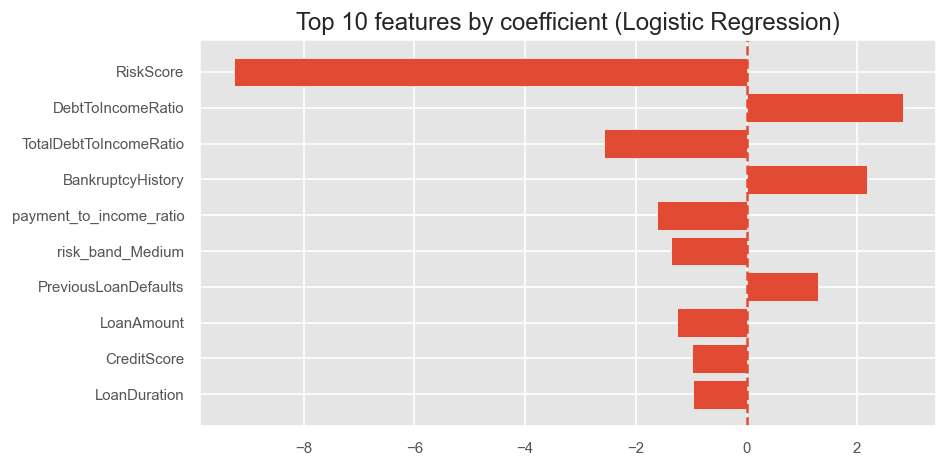

<Figure size 960x540 with 0 Axes>

In [46]:
plt.style.use("ggplot")

feat_imp = feature_importance_df.copy()
feat_imp["abs_coef"] = feat_imp["coefficient"].abs()
top10 = feat_imp.sort_values("abs_coef", ascending=False).head(10)

plt.figure(figsize=(8, 4))
plt.barh(top10["feature"], top10["coefficient"])
plt.axvline(0, linestyle="--")
plt.title("Top 10 features by coefficient (Logistic Regression)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
plt.savefig("figures/top10_feature_coefficients.png", dpi=300)

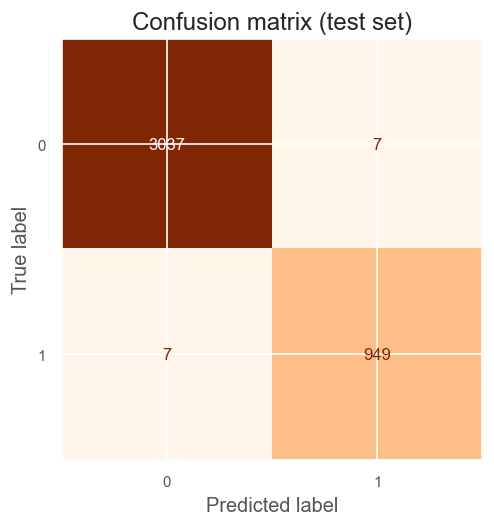

<Figure size 960x540 with 0 Axes>

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(
    cmap="Oranges",
    colorbar=False,
)

plt.title("Confusion matrix (test set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.tight_layout()
plt.show()
plt.savefig("figures/confusion_matrix.png", dpi=300)


In [45]:
# Power BI export table

# 1) Make sure indices between model_df and policy_df align
assert len(model_df) == len(policy_df), "model_df and policy_df have different lengths!"
assert (model_df.index == policy_df.index).all(), "Indices are misaligned!"

# 2) Start from a slim business view
bi_df = pd.DataFrame({
    "RiskScore": model_df["RiskScore"],
    "CreditScore": model_df["CreditScore"],
    "AnnualIncome": model_df["AnnualIncome"],
    "income_band": model_df["income_band"],
    "LoanAmount": model_df["LoanAmount"],
    "loan_amount_band": model_df["loan_amount_band"],
    "LoanDuration": model_df["LoanDuration"],
    "loan_duration_band": model_df["loan_duration_band"],
    "DebtToIncomeRatio": model_df["DebtToIncomeRatio"],
    "TotalDebtToIncomeRatio": model_df["TotalDebtToIncomeRatio"],
    "payment_to_income_ratio": model_df["payment_to_income_ratio"],
    "risk_band": model_df["risk_band"],
    "LoanApproved": model_df["LoanApproved"],
})

# 3) Add ML outputs & flags
bi_df["pred_approval_prob"] = policy_df["pred_approval_prob"]
bi_df["prob_band"] = policy_df["prob_band"]
bi_df["high_conf_under_approved"] = policy_df["high_conf_under_approved"]
bi_df["high_conf_over_approved"] = policy_df["high_conf_over_approved"]

# 4) Single exception_type column for easy filtering in BI
bi_df["exception_type"] = "none"
bi_df.loc[bi_df["high_conf_under_approved"] == 1, "exception_type"] = "high_conf_under_approved"
bi_df.loc[bi_df["high_conf_over_approved"] == 1, "exception_type"] = "high_conf_over_approved"

display(bi_df.head())
print("BI export shape:", bi_df.shape)

# 5) Save for Power BI
bi_df.to_csv("data/loan_policy_bi_export.csv", index=False)
print("Saved loan_policy_bi_export.csv")

,RiskScore,CreditScore,AnnualIncome,income_band,LoanAmount,loan_amount_band,LoanDuration,loan_duration_band,DebtToIncomeRatio,TotalDebtToIncomeRatio,payment_to_income_ratio,risk_band,LoanApproved,pred_approval_prob,prob_band,high_conf_under_approved,high_conf_over_approved,exception_type
0,49.0,617,39948,30k-60k,13152,5k-20k,48,37-60m,0.358336,0.181077,0.126106,Medium,0,0.027387,low_conf_reject,0,0,none
1,52.0,628,39709,30k-60k,26045,20k-50k,48,37-60m,0.330274,0.389852,0.239962,Medium,0,0.000010,low_conf_reject,0,0,none
2,52.0,570,40724,30k-60k,17627,5k-20k,36,13-36m,0.244729,0.462157,0.196368,Medium,0,0.000033,low_conf_reject,0,0,none
3,54.0,545,69084,60k-100k,37898,20k-50k,96,60m+,0.436244,0.313098,0.181954,Medium,0,0.000010,low_conf_reject,0,0,none
4,36.0,594,103264,100k+,9184,5k-20k,36,13-36m,0.078884,0.070210,0.038369,Low,1,0.999996,low_conf_approve,0,0,none


BI export shape: (20000, 18)
Saved loan_policy_bi_export.csv


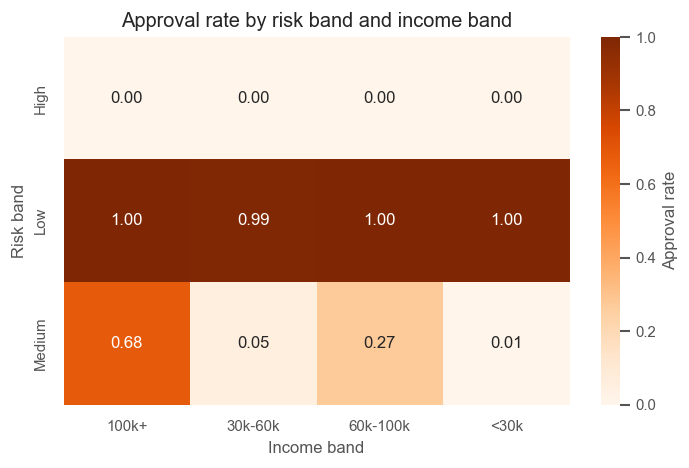

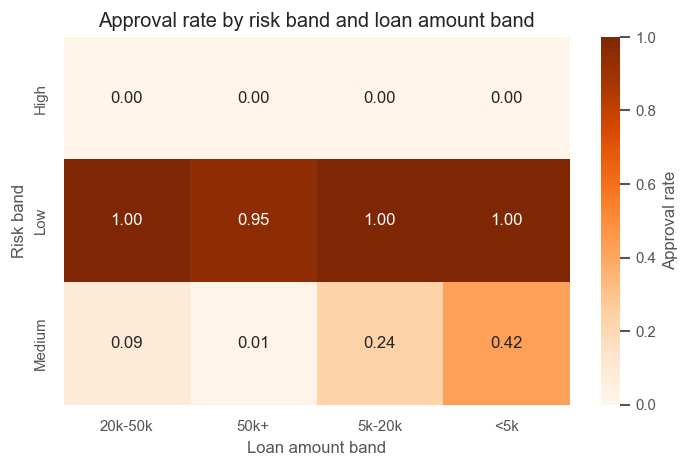

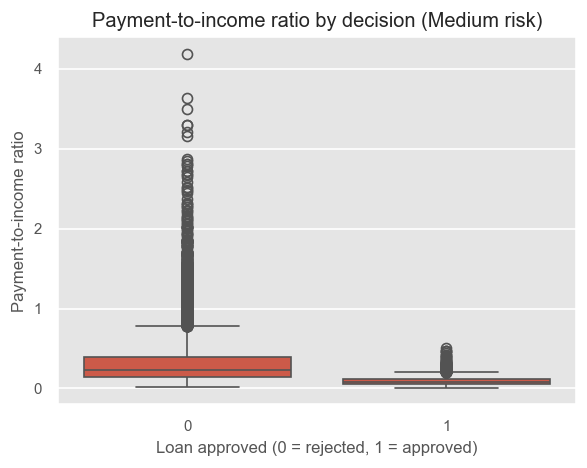

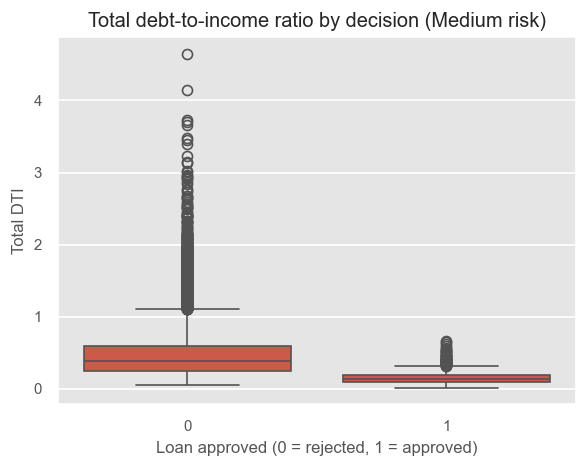

/var/folders/hv/mm029zcj2j1cm_qjq29d9b8c0000gn/T/ipykernel_27999/155605585.py:122: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("prob_band")["LoanApproved"]


,prob_band,approval_rate
0,low_conf_reject,0.000332
1,uncertain,0.478548
2,low_conf_approve,0.999137


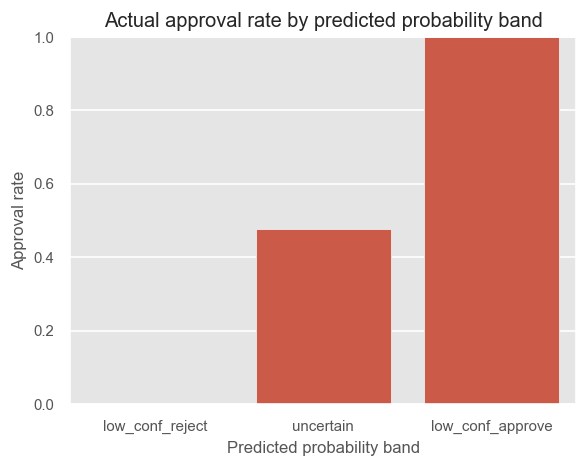

,exception_type,RiskScore,income_band,loan_amount_band,payment_to_income_ratio,TotalDebtToIncomeRatio,pred_approval_prob,LoanApproved
2538,high_conf_over_approved,44.0,30k-60k,20k-50k,0.323218,0.590580,0.047316,1
3970,high_conf_under_approved,40.0,60k-100k,5k-20k,0.082176,0.119796,0.970774,0
8429,high_conf_over_approved,45.6,30k-60k,20k-50k,0.178874,0.250418,0.079155,1
8847,high_conf_over_approved,48.0,60k-100k,20k-50k,0.177268,0.244025,0.038351,1
11614,high_conf_under_approved,45.0,60k-100k,5k-20k,0.107195,0.145607,0.940297,0
14937,high_conf_under_approved,51.0,60k-100k,5k-20k,0.063322,0.093358,0.975633,0
15635,high_conf_over_approved,43.2,30k-60k,50k+,0.438326,0.531125,0.004220,1
18216,high_conf_over_approved,44.8,60k-100k,20k-50k,0.141613,0.234444,0.066910,1
18258,high_conf_under_approved,47.0,60k-100k,5k-20k,0.056031,0.141493,0.907117,0


,exception_type,count
0,high_conf_over_approved,5
1,high_conf_under_approved,4


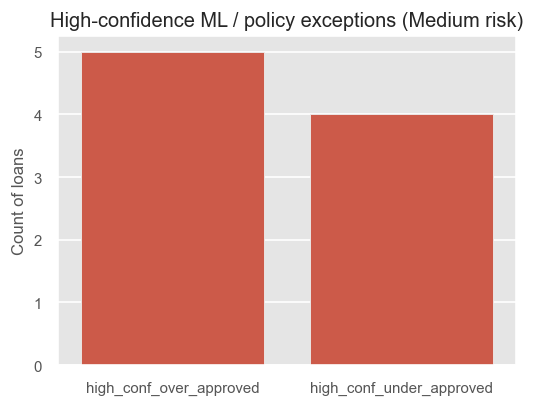

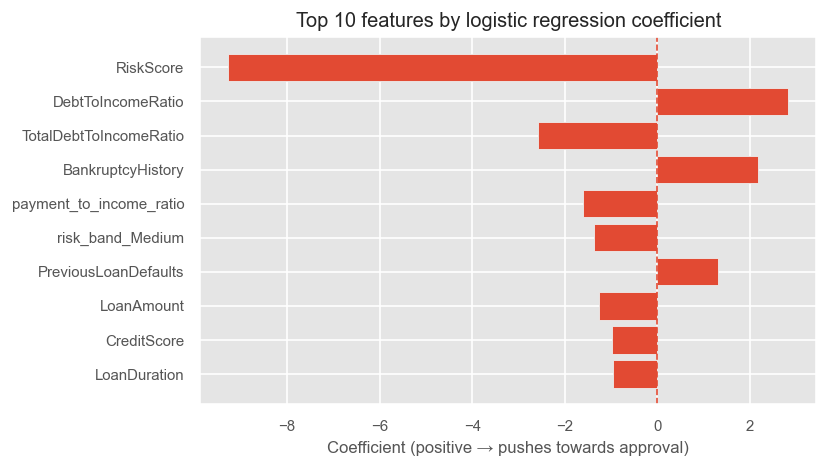

<Figure size 540x480 with 0 Axes>

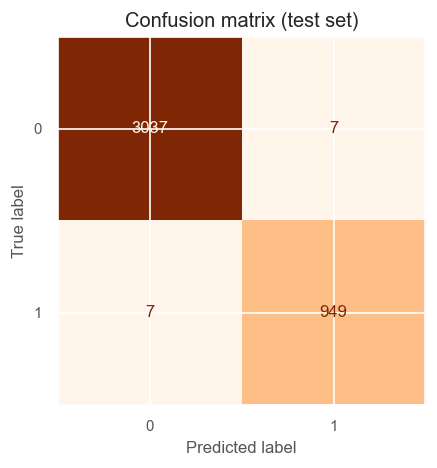

Test ROC-AUC: 1.000


<Figure size 600x480 with 0 Axes>

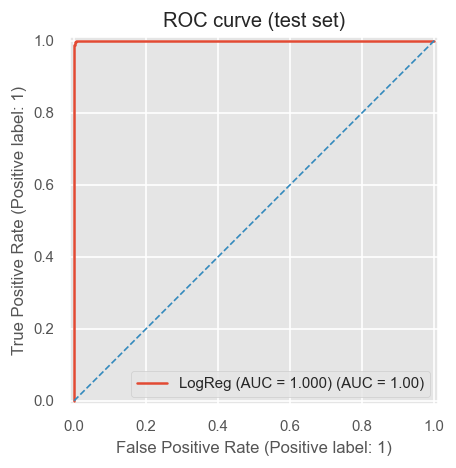

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

# Create figures folder if it doesn't exist
os.makedirs("figures", exist_ok=True)

# Styling
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["xtick.labelsize"] = 9
plt.rcParams["ytick.labelsize"] = 9
plt.rcParams["legend.fontsize"] = 9

# =========================
# 1) Policy behaviour heatmaps
# =========================

# 1.1 Approval rate by risk_band × income_band
pivot_risk_income = (
    model_df
    .pivot_table(
        index="risk_band",
        columns="income_band",
        values="LoanApproved",
        aggfunc="mean"
    )
    .sort_index()
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    pivot_risk_income,
    annot=True,
    fmt=".2f",
    cmap="Oranges",
    cbar_kws={"label": "Approval rate"}
)
plt.title("Approval rate by risk band and income band")
plt.xlabel("Income band")
plt.ylabel("Risk band")
plt.tight_layout()
plt.savefig("figures/heatmap_risk_income.png", dpi=300)
plt.show()

# 1.2 Approval rate by risk_band × loan_amount_band
pivot_risk_loan = (
    model_df
    .pivot_table(
        index="risk_band",
        columns="loan_amount_band",
        values="LoanApproved",
        aggfunc="mean"
    )
    .sort_index()
)

plt.figure(figsize=(6, 4))
sns.heatmap(
    pivot_risk_loan,
    annot=True,
    fmt=".2f",
    cmap="Oranges",
    cbar_kws={"label": "Approval rate"}
)
plt.title("Approval rate by risk band and loan amount band")
plt.xlabel("Loan amount band")
plt.ylabel("Risk band")
plt.tight_layout()
plt.savefig("figures/heatmap_risk_loan.png", dpi=300)
plt.show()

# =========================
# 2) Affordability in Medium risk (PTI / DTI)
# =========================

medium_df = model_df[model_df["risk_band"] == "Medium"].copy()

# 2.1 PTI by decision
plt.figure(figsize=(5, 4))
sns.boxplot(
    data=medium_df,
    x="LoanApproved",
    y="payment_to_income_ratio"
)
plt.title("Payment-to-income ratio by decision (Medium risk)")
plt.xlabel("Loan approved (0 = rejected, 1 = approved)")
plt.ylabel("Payment-to-income ratio")
plt.tight_layout()
plt.savefig("figures/boxplot_medium_pti.png", dpi=300)
plt.show()

# 2.2 Total DTI by decision
plt.figure(figsize=(5, 4))
sns.boxplot(
    data=medium_df,
    x="LoanApproved",
    y="TotalDebtToIncomeRatio"
)
plt.title("Total debt-to-income ratio by decision (Medium risk)")
plt.xlabel("Loan approved (0 = rejected, 1 = approved)")
plt.ylabel("Total DTI")
plt.tight_layout()
plt.savefig("figures/boxplot_medium_dti.png", dpi=300)
plt.show()

# =========================
# 3) Model calibration: probability bands
# =========================

policy_df = policy_df.copy()
if "prob_band" not in policy_df.columns:
    policy_df["prob_band"] = pd.cut(
        policy_df["pred_approval_prob"],
        bins=[0.0, 0.1, 0.9, 1.0],
        labels=["low_conf_reject", "uncertain", "low_conf_approve"],
        include_lowest=True
    )

band_stats = (
    policy_df
    .groupby("prob_band")["LoanApproved"]
    .mean()
    .reset_index()
    .rename(columns={"LoanApproved": "approval_rate"})
)

display(band_stats)

plt.figure(figsize=(5, 4))
sns.barplot(
    data=band_stats,
    x="prob_band",
    y="approval_rate"
)
plt.title("Actual approval rate by predicted probability band")
plt.xlabel("Predicted probability band")
plt.ylabel("Approval rate")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("figures/bar_prob_band_calibration.png", dpi=300)
plt.show()

# =========================
# 4) High-confidence anomalies (Medium risk)
# =========================

# Build anomalies df from model_df + policy_df
anomaly_df = model_df.copy()
anomaly_df["pred_approval_prob"] = policy_df["pred_approval_prob"]
anomaly_df["prob_band"] = policy_df["prob_band"]
anomaly_df["high_conf_under_approved"] = policy_df["high_conf_under_approved"]
anomaly_df["high_conf_over_approved"] = policy_df["high_conf_over_approved"]

# Only Medium risk
anomaly_df = anomaly_df[anomaly_df["risk_band"] == "Medium"].copy()

# Exception type
anomaly_df["exception_type"] = "none"
anomaly_df.loc[anomaly_df["high_conf_under_approved"] == 1, "exception_type"] = "high_conf_under_approved"
anomaly_df.loc[anomaly_df["high_conf_over_approved"] == 1, "exception_type"] = "high_conf_over_approved"

exceptions = anomaly_df[anomaly_df["exception_type"] != "none"].copy()

# Show table in notebook (for you)
display(exceptions[[
    "exception_type",
    "RiskScore",
    "income_band",
    "loan_amount_band",
    "payment_to_income_ratio",
    "TotalDebtToIncomeRatio",
    "pred_approval_prob",
    "LoanApproved"
]])

# Bar chart of counts by exception_type
if exceptions.empty:
    print("No high-confidence exceptions to plot.")
else:
    count_exceptions = (
        exceptions["exception_type"]
        .value_counts()
        .rename("count")
        .reset_index()
        .rename(columns={"index": "exception_type"})
    )

    display(count_exceptions)

    plt.figure(figsize=(4.5, 3.5))
    sns.barplot(
        data=count_exceptions,
        x="exception_type",
        y="count",
    )
    plt.title("High-confidence ML / policy exceptions (Medium risk)")
    plt.xlabel("")
    plt.ylabel("Count of loans")
    plt.tight_layout()
    plt.savefig("figures/bar_exceptions_counts.png", dpi=300)
    plt.show()


# =========================
# 5) Feature importance (top 10 |coef|)
# =========================

feat_imp = feature_importance_df.copy()
feat_imp["abs_coef"] = feat_imp["coefficient"].abs()
top10 = feat_imp.sort_values("abs_coef", ascending=False).head(10)

plt.figure(figsize=(7, 4))
plt.barh(top10["feature"], top10["coefficient"])
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Top 10 features by logistic regression coefficient")
plt.xlabel("Coefficient (positive → pushes towards approval)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("figures/bar_feature_importance_top10.png", dpi=300)
plt.show()

# =========================
# 6) Confusion matrix (test set)
# =========================

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4.5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(
    cmap="Oranges",
    colorbar=False,
)
plt.title("Confusion matrix (test set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.savefig("figures/confusion_matrix_test.png", dpi=300)
plt.show()

# =========================
# 7) ROC curve (test set)
# =========================

y_test_probs = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_test_probs)
print(f"Test ROC-AUC: {auc:.3f}")

plt.figure(figsize=(5, 4))
RocCurveDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    name=f"LogReg (AUC = {auc:.3f})"
)
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.title("ROC curve (test set)")
plt.tight_layout()
plt.savefig("figures/roc_curve_test.png", dpi=300)
plt.show()
